# Tutorial 2 - Multiple linear regression with Regularization

Welcome to the second tutorial of the course 'Machine learning for Precision Medicine'.

In the last tutorial we calculated the best coefficients to predict the Insulin level from BMI with a simple linear regression model. However, the prediction was not very accurate. In an effort to get more accurate predictions, we will take more parameters (predictors) from the dataset into account by using a multiple linear regression model. Our predictors will now be: Pregnancies, Glucose, BloodPressure, SkinThickness, BMI, the Pedigree-score and Age.

(The pedigree score provides information about patients' genetic susceptibility for developing diabetes. Understanding this score is not important for this tutorial. Just keep in mind, it represents the diabetes mellitus history in relatives and the genetic relationship of those relatives to the patient.)

But let's look at the dataset again first.

In [213]:
# Import python libraries.

import pandas as pd
import numpy as np

# for manipulation of graph and figures
from matplotlib import pyplot as plt



In [214]:
# this loads the data into a pandas DataFrame, './diabetes.csv' specifies the directory for the datafile
df = pd.read_csv('./diabetes.csv')

# look at the first 5 rows of the dataset
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


***

In contrast to our previous exercise, where we had observations $(\mathit x,\mathit y)$ where both $\mathit x$ and $\mathit y$ were scalar variables, we now have pairs of $(\mathbf x,\mathit y)$, where boldface $\mathbf x$ refers to the fact that $\mathbf x$ is a column vector.

Previous fomula:  
$\mathit y = a + b * BMI$

Whereas previously, we only had to find two parameters $a$ (intercept or bias) and $b$ (slope), we now have to find a parameter for each of the predictor variables. We will include the parameters in the parameter vector $\theta$.

New formula: 
$y = a + \theta_1 * BMI + \theta_2 * Glucose + \theta_3 * SkinThickness + \theta_4 * Age + \theta_5 * Pedigree$



### Matrix notation of the Least Squares regression problem

For a single observation we can write down the relationship above as a scalar product (also called dot product) of two vectors, $\mathbf θ$ (our parameters) and $\mathbf x$. Since $\mathbf x$ is a column vector, we need to transpose it first into row vector.

$$ \mathbf x^T \mathbf θ + a \approx \mathit y $$

However, we will find it useful to directly include the bias parameter $a$ inside our parameter vector, i.e. $a = \mathbf θ_0$. For this we have to prepend all observations $\mathbf x$ by a constant of 1 in order to arrive at a completely vectorized notation:
$$ \mathbf x^{T} \mathbf θ \approx \mathit y $$

This way the first element of $\mathbf θ$ corresponds to the bias:

$$ \mathbf x = [1, \mathbf x_1, \mathbf x_2, ... , \mathbf x_n ]^T $$
$$ \mathbf θ = [\theta_0, \theta_1, \theta_2, ..., \theta_n] $$

So far, we have looked at single pairs of $(\mathbf x, \mathit y )$. We now expand our view to the entire dataset with all observations $\mathbf X$ and $\mathbf y$. Where $\mathbf X$ is the matrix that results of stacking all vectors $\mathbf x^T$ (including the prepended constant) on top of each other, resulting in $ n * d $ matrix, where $n$ is the number of observations (rows) and $d$ is the number of elements in each vector $\mathbf x$ (number of independant variables + 1). Thus $d$ corresponds to the number of parameters of our linear regression model. $\mathbf y$ is the vector of the corresponding Insulin-values.

In matrix notation we can write the complete system of equations as:

$$\mathbf X  \mathbf θ \approx \mathbf y $$ 

$$ \begin{pmatrix} —\enspace{x^T}\:^{(1)}\enspace—\\ —\enspace{x^T}\:^{(2)}\enspace—\\.\\.\\ —\enspace{x^T}\:^{(n)}\enspace—\end{pmatrix} \begin{pmatrix} θ_{0} \\θ_{1}\\.\\.\\θ_{d}\end{pmatrix}  \approx  \begin{pmatrix} {y}\:^{(1)}\\ {y}\:^{(2)}\\.\\.\\ {y}\:^{(n)}\end{pmatrix} $$



Now, we need to estimate the parameters $\theta$, that minimize the squared difference between predicted values $\hat{y}$ and true values of $y$.

In [215]:
# Pre-processing the dataset:

# we remove the variable "Outcome" from the table:
data = df.drop('Outcome',1)

# we remove rows with missing values (0) from the table:
data = data[(data != 0).all(1)]


It's usually a good idea to visualize the variables of your model in order to get an idea of how they are distributed. Here we plot a histograms of some of the variabes in order to get an idea of how our variables are distributed.

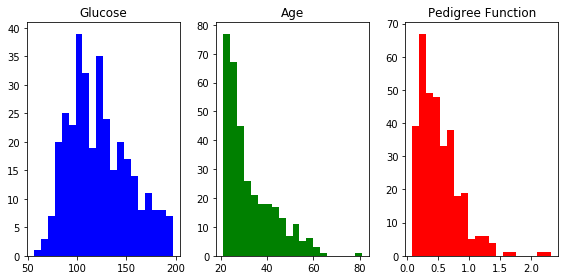

In [216]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(8, 4))
ax0.hist(data['Glucose'], 20, density=False, facecolor='b')
ax0.set_title('Glucose')
ax1.hist(data['Age'], 20, density=False, facecolor='g')
ax1.set_title('Age')
ax2.hist(data['DiabetesPedigreeFunction'], 20, density=False, facecolor='r')
ax2.set_title('Pedigree Function')
fig.tight_layout()

**Question 1**:  
Above we have produced histograms of Glucose, Age and DiabetesPedigreeFunction.

What is shown on the x-axis? what is the y-axis?

x-axis:range of values,
y-axis:number of records for corresponding value

As illustrated above, the different variables have vastly different scales. This can make it hard to interpret the coefficients of our linear regression model, because they will depend on the original scales of each variable. For this reason, we would like to standardize the variables by calculating *z-scores*, where

$$ z = \frac{(x - \bar x)}{\sigma} $$

This way, all variables have a mean of 0 and standard deviation $\sigma$ of 1 and our coefficients will be more comparable between each other.

Before we standardize, we would like to keep track of the original means and standard deviations.

## Task 1:

Calculate the mean and standard deviation for each column of the DataFrame `data`.


In [238]:
means= np.mean(data,axis=0)# your_code (one function call!)
standard_deviations =np.std(data,axis=0)# your_code (one function call!)
print(standard_deviations)



Pregnancies                   3.143663
Glucose                      30.738805
BloodPressure                12.344990
SkinThickness                10.234599
Insulin                     118.600398
BMI                           6.359074
DiabetesPedigreeFunction      0.327201
Age                          10.442871
dtype: float64


## Task 2:

Write a function `zscore(x)` that for a given numpy-array `x`, returns the standardized values. We then apply this function to all the columns of `data`.

*hint: Use numpy functions! Make sure you known what DataFrame.apply() does*

In [239]:
def zscore(x):

    return (x-np.mean(x))/np.std(x)# your_code

standardizeddata = data.apply(zscore)
standardizeddata.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
3,-0.906964,-1.082663,-0.343787,-0.553387,-0.517268,-0.660052,-1.074881,-1.037675
6,-0.270764,-1.440517,-1.639859,0.325983,-0.567858,-0.204011,-0.827327,-0.558880
8,-0.588864,2.430811,-0.019769,1.596185,3.268554,-0.282639,-1.102387,2.026616
13,-0.906964,2.170554,-0.829814,-0.553387,5.823351,-0.345541,-0.368893,2.601171
14,0.365437,1.422314,0.142240,-0.944218,0.165697,-1.021740,0.208733,1.835098


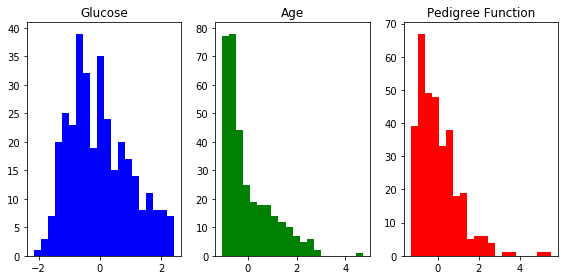

In [241]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(8, 4))
ax0.hist(standardizeddata['Glucose'], 20, density=False, facecolor='b')
ax0.set_title('Glucose')
ax1.hist(standardizeddata['Age'], 20, density=False, facecolor='g')
ax1.set_title('Age')
ax2.hist(standardizeddata['DiabetesPedigreeFunction'], 20, density=False, facecolor='r')
ax2.set_title('Pedigree Function')
fig.tight_layout()


Notice how the scales have changed in the plots above.

In [220]:
# Let's define x and y. x are our observations and y is what we want to predict.

indep_vars = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age']
dep_var = ['Insulin']

x = standardizeddata[indep_vars]
y = standardizeddata[dep_var]

x = np.array(x)
y = np.array(y)

n = x.shape[0]
d = x.shape[1]

# add a column of ones to the left of x
X = np.insert(x, [0], 1, axis=1)

print('number of samples n =', n, 'and number of features d =', d)

number of samples n = 336 and number of features d = 7


From the lecture we know that the least squares solution can be obtained using the formula:

$$ \mathbf θ = (\mathbf X^T \mathbf X)^{-1}\;\mathbf X^T \mathbf y $$

## Task 3:
Write a function `least_squares(x,y)` that implements the calculation above using numpy (x and y are [numpy.ndarray](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html)). Finally, write a function that takes a matrix of observations and a parameter vector $\mathbf θ$ (theta), and returns a vector of predictions `y_hat`.

*hint: numpy.linalg.inv() , numpy.ndarray.transpose(), numpy.ndarray.dot()*

In [242]:
def least_squares(x,y):
    # your code (roughly 2-3 lines)
    trans=np.ndarray.transpose(x)
    inner=np.ndarray.dot(trans,x)
    inver = np.linalg.inv(inner)
    theta=np.ndarray.dot(np.ndarray.dot(inver,trans),y)

    return theta


In [243]:
def predict(x, theta):
    # your code
    
    y_hat=np.ndarray.dot(x,theta)
    return y_hat


Above we placed our predictor variables into the matrix $\mathbf X$ and we set up our output vector $\mathbf y$. Before we fit our model, we design our machine-learning experiment:

We fit our model-parameters $\theta$ using the training set. The validation-set is used for hyper-parameter tuning (we do this later in the exercise for L2-regularized least-squares). The performance on the test-set will give us our final performance-estimate.

Therefore, we have to split our dataset into training, test and validation sets. We will do this, using the popular python machine learning library 'scikit-learn'. The library provides a function called `train_test_split()`. Read the docs about it [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

The function requires our data matrix $\mathbf X$ and output vector $\mathbf y$ as inputs and will output the same data but divided into training and test subsets. How much data we want to use for validation/testing, is defined by the `test_size`-parameter.

We use the scikit-learn function `train_test_split()` to split your data into training, test and validation sets:

In [244]:
# Import the fuction from the scikit-learn library
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

**Question 2**: After performing the operation above, How many % of the original data X are part of the train-, validation- and test-set, respectively? 

train: 70 %
validation: 15 %
test: 15 %

## Task 4:  
Fit your model on `X_train` and `y_train` using your `least_squares`-function from above:

In [245]:
theta = least_squares(X_train,y_train)# your_code


In [246]:
# we have a look at the resulting parameters

var_label = ['bias'] + indep_vars
for i, p in enumerate(theta):
    print("{}: {:.3f}".format(var_label[i], float(p)))

bias: -0.029
Pregnancies: -0.187
Glucose: 0.544
BloodPressure: -0.053
SkinThickness: 0.030
BMI: 0.081
DiabetesPedigreeFunction: 0.141
Age: 0.204


**Expected Output:**  
bias: -0.029  
Pregnancies: -0.187  
Glucose: 0.544  
BloodPressure: -0.053  
SkinThickness: 0.030  
BMI: 0.081  
DiabetesPedigreeFunction: 0.141  
Age: 0.204  

Predict on the validation set:

In [247]:
y_hat = predict(X_valid, theta)

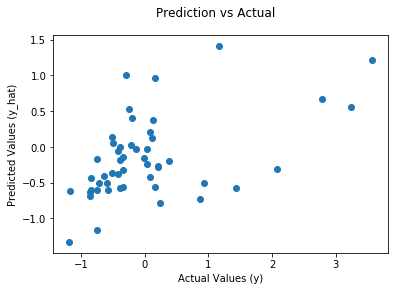

In [248]:
# this produces a plot of y_hat vs y
plt.scatter(y_valid, y_hat)
plt.xlabel('Actual Values (y)')
plt.ylabel('Predicted Values (y_hat)')
plt.suptitle('Prediction vs Actual')
plt.show()

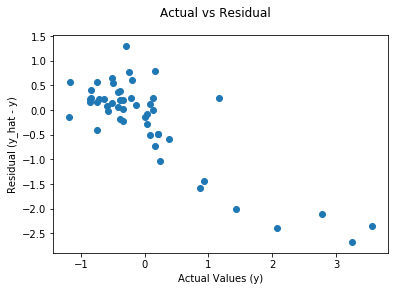

In [249]:
# this produces a plot of the residual vs y
plt.scatter(y_valid, y_hat - y_valid)
plt.xlabel('Actual Values (y)')
plt.ylabel('Residual (y_hat - y)')
plt.suptitle('Actual vs Residual')
plt.show()

**Question 3**:  
What do you see in the 'Actual vs Residual' plot above? In which areas are you over-estimating y? In which areas are you under-estimating y? What could be the reason for this behavior?

Write your answer in the cell below.

For actual values of y below 0 we see over estimation.For high value of y like 3 we see underestimation.

***
### Regularized Least Squares

In the lecture we discussed the concept of regularization.

**Question 4:**  
Why do we use regularization?

to avoid overfitting by reducing the complexity of model by reducing parameter weights

In the lecture we discussed the formula for regularized least squares using an L2-regularization term.

$$  \mathbf θ =  \begin{bmatrix} \frac{1}{n}\mathbf X^{T}\mathbf X+ \mathit \lambda I \end{bmatrix}^{-1} \begin{bmatrix}\frac{1}{n}\mathbf X^{T}\mathbf Y \end{bmatrix}$$



## Task 5:  
Implement the function `regularized_least_squares(x,y,lambd)`, which calculates the above mentioned equation for a given data matrix `x`, outcome variable `y`, and regularization parameter `lambd`:

In [250]:
def regularized_least_squares(x,y,lambd):
    
    n = x.shape[0]
    m = x.shape[1]  
    
    # your_code
    trans=np.ndarray.transpose(x)
    inner=(1/(n))*np.ndarray.dot(trans,x)  #scalar
    addI=inner+lambd*np.identity(m)   #matrix 7*7 
    inver = np.linalg.inv(addI)   
    xDotY=(1/n)*np.ndarray.dot(trans,y)  
    theta=np.ndarray.dot(inver,xDotY)    

    return theta 


## Task 6:  

Fit a model for different values of $\lambda$. Append the results to the list `thetas`.

In [251]:
# we initialize a vector L of values we want to use for lambda
# start : 10.
# end: 1e-4
L = 10 ** np.linspace(start=1., stop=-4, num=41)

thetas = []

# note: we could also do this with a list comprehension
for lambd in L:
    
    theta = regularized_least_squares(X_train,y_train,lambd)# your code
    thetas.append(theta)
    
thetas = np.array(thetas)


## Task 7:    
Predict on the  validation set for all the different values of theta, calculate the mean squared error and append the mean squared error to the list `mse`.

In [252]:
mse = []


for i in range(len(L)):
    # your code    
    y_hatReg=np.ndarray.dot(X_valid,thetas[i])    
    a = np.square(y_hatReg-y_valid)
    b=np.mean(a)    
    mse.append(b) 
    
    


print('mse: [{:.4f}, {:.4f} ... {:.4f}, {:.4f}]'.format(mse[0],mse[1],mse[-2],mse[-1]))

mse: [0.9696, 0.9539 ... 0.8038, 0.8039]


**Expected Output**:  
mse: [0.9696, 0.9539, ... , 0.8038, 0.8039]

We plot the performance of our model vs -log10($\lambda$):

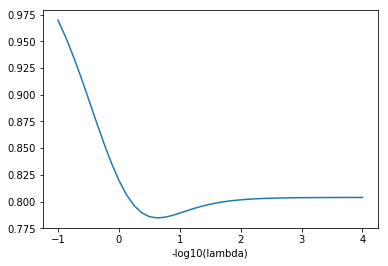

In [253]:
plt.plot(-1 * np.log10(np.array(L)), mse)
plt.xlabel('-log10(lambda)')
plt.show()

**Question 5**:

Investigate the graph above. How would you visually identify the best value for lambda?

write your answer here : lowest value for MSE occurs for log value of lambda a little less than 1 so it would be the best value.

## Task 8:

Retrieve the index `best_i` of the lambda-value in `L` that gave the best performance.

Retrieve the corresponding value of lambda, and store it in `best_lambd`. Retrieve the parameters for that model and store them in `best_theta`.

*hint: np.argmin()*

In [254]:
# find the best set of parameters theta:
# this should not take more the 3 lines of code

best_i =np.argmin(mse) # your_code
best_lambd = L[best_i]# your_code
best_theta =thetas[best_i] # your_code

In [255]:
print('best lambda: {}'.format(best_lambd))

print('## best parameters ')
for i, p in enumerate(best_theta):
    print("{}: {:.3f}".format(var_label[i], float(p)))

best lambda: 0.23713737056616552
## best parameters 
bias: -0.016
Pregnancies: -0.095
Glucose: 0.442
BloodPressure: -0.026
SkinThickness: 0.040
BMI: 0.066
DiabetesPedigreeFunction: 0.126
Age: 0.150


** Expected Output: **

best lambda: 0.237

\#\# best parameters  
bias: -0.016  
Pregnancies: -0.095  
Glucose: 0.442  
BloodPressure: -0.026  
SkinThickness: 0.040  
BMI: 0.066  
DiabetesPedigreeFunction: 0.126  
Age: 0.150

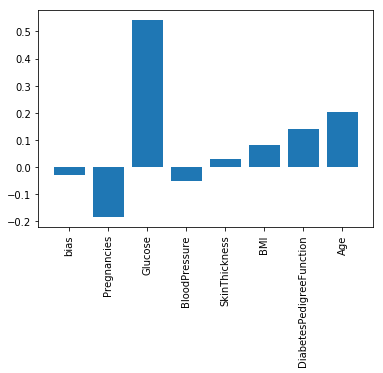

In [256]:
# we can also visualize the best parameters with a bar-plot:
plt.bar(var_label, theta[:,0])
plt.xticks(rotation='vertical')
plt.show()

Finally, we compare the performance of the regularized vs the un-regularized model on the test set:

In [257]:
unregularized_yhat = predict(X_test, theta)
regularized_yhat = predict(X_test, thetas[best_i, :, :])

mse_unregularized = np.mean(np.square(y_test - unregularized_yhat))
mse_regularized = np.mean(np.square( y_test - regularized_yhat))

print('Least Squares MSE: {}'.format(mse_unregularized))
print('L2-regularized Least Squares MSE: {}'.format(mse_regularized))

Least Squares MSE: 0.5831927067759521
L2-regularized Least Squares MSE: 0.5651029073296518


** Expected Output **:  

Least Squares MSE: 0.5832  
L2-regularized Least Squares MSE: 0.5651

## Discussion

Look at the bar-plot of coefficients above. Discuss with your team-mates:

 - What do you think are the most important variables to predict Insulin
 - Do these intuitively make sense?
 - What kind of analysis would further help you to understand the relationship between the different predictor variables?
 - Would you give this model to a clinic?

## Note:

Above we implemented L2-regularized linear regression using numpy. However, the [scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) package already includes Ridge regression and other types of regularized linear models. In practice it is strongly preferable to use those provided functions. However, you would not have learned any numpy-operations and the mathematical concepts ;)



Congratulations, you made it through the second tutorial of this course!  

# Submitting your assignment

Please rename your notebook under your full name and send it to machinelearning.dhc@gmail.com.  
If you have a google account, you can also share your jupyter-file on Google Drive with this eMail address.

Please rename the file to 1_LinRegTut_<GROUP\>.ipynb and replace <GROUP\> with your group-name.

As this is also the first time for us preparing this tutorial, you are welcome to give us feedback to help us improve this tutorial.  

Thank you!  

Jana & Remo